In [104]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow import keras as K, nn

In [105]:
y, sr = sf.read('training-lax_no_presence.wav', dtype='float32')

In [106]:
y

array([0.0163269 , 0.01556396, 0.0163269 , ..., 0.00238037, 0.00305176,
       0.00323486], shape=(960000,), dtype=float32)

In [107]:
sr

16000

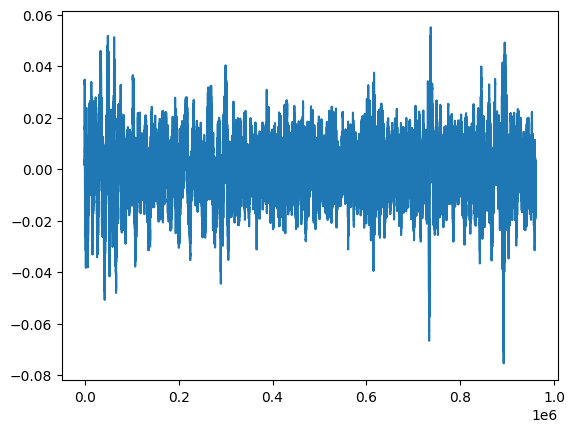

In [108]:
plt.plot(range(0, 960000), y)

In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for  i in range(0, len(lst), n):
        if(i+n > len(lst)):
            return
        yield lst[i:i + n]
        
SAMPLE_RATE = 16000  # change to your real value
BIN_WIDTH = 12
CHUNK_SIZE = SAMPLE_RATE // BIN_WIDTH  # e.g., 4000 for 16 kHz


def chunk_fft_features(signal, chunk_size=CHUNK_SIZE):
    "Split audio into fixed chunks and return magnitude FFT features."
    chunked = np.asarray(list(chunks(signal, chunk_size)))
    fft_mag = np.abs(np.fft.rfft(chunked, axis=1))
    return fft_mag.astype(np.float32)

In [ ]:
import glob
import os

presence_files = glob.glob("*presence*.wav")
no_presence_files = glob.glob("*no_presence*.wav")

# Remove files from presence_files that have a matching base name in no_presence_files
no_presence_basenames = {os.path.basename(f).replace("no_presence", "") for f in no_presence_files}

presence_files = [
    f for f in presence_files
    if os.path.basename(f).replace("presence", "") not in no_presence_basenames
]

print(presence_files)


In [ ]:
presence_data_chunks = []
sample_rate = None
for f in presence_files:
    data, sr = sf.read(f, dtype='float32')

    if sample_rate is None:
        sample_rate = sr
    elif sr != sample_rate:
        raise ValueError(f"Sample rate mismatch in {f}: {sr} != {sample_rate}")

    presence_data_chunks.append(data)

# Concatenate all into one long array
presence_data = np.concatenate(presence_data_chunks)

print("Shape:", presence_data.shape)

In [ ]:
no_presence_data_chunks = []
sample_rate = None
for f in no_presence_files:
    data, sr = sf.read(f, dtype='float32')

    if sample_rate is None:
        sample_rate = sr
    elif sr != sample_rate:
        raise ValueError(f"Sample rate mismatch in {f}: {sr} != {sample_rate}")

    no_presence_data_chunks.append(data)

# Concatenate all into one long array
no_presence_data = np.concatenate(no_presence_data_chunks)

print("Shape:", no_presence_data.shape)

In [ ]:
data_np = np.asarray(list(chunk_fft_features(no_presence_data)))
labels_np = np.zeros(len(data_np))

In [ ]:
data_p = np.asarray(list(chunk_fft_features(presence_data)))
labels_p = np.ones(len(data_p))

In [ ]:
data_p.shape

In [ ]:
data_final = np.concatenate((data_np, data_p))
labels_final = np.concatenate((labels_np, labels_p))

In [ ]:
train_data, validation_data, train_labels, validation_labels= train_test_split(data_final, labels_final, test_size=0.2, shuffle=True)

In [ ]:
train_data.shape

In [ ]:
# Reshape data for Conv1D
train_data_reshaped = train_data.reshape(-1, train_data.shape[1], 1)
validation_data_reshaped = validation_data.reshape(-1, validation_data.shape[1], 1)

#model = K.models.Sequential()
#model.add(K.layers.Conv1D(filters=10, kernel_size=12, activation='relu', input_shape=(train_data.shape[1], 1)))
#model.add(K.layers.MaxPool1D(pool_size=2))
#model.add(K.layers.Conv1D(filters=8, kernel_size=4, activation='relu'))
#model.add(K.layers.MaxPool1D(pool_size=2))
#model.add(K.layers.Flatten())
#model.add(K.layers.Dense(32, activation='relu'))
#model.add(K.layers.Dense(1, activation='sigmoid'))

model = K.models.Sequential()
model.add(K.layers.Conv1D(filters=1, kernel_size=2, activation='relu', input_shape=(train_data.shape[1], 1)))
model.add(K.layers.MaxPool1D(pool_size=2))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='relu'))
model.add(K.layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(train_data, train_labels, validation_data=(validation_data, validation_labels), epochs=5, verbose=1)